### Installing Autokeras

In [1]:

# Install AutoKeras
!pip3 install autokeras

     |████████████████████████████████| 174kB 8.6MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=fa6debf4662a712a8c4f5dde4ce5a7a157d5246af6aca833af45a7378c6fa879
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=05a88e03f7c505a1759c466b59f29002888b75485dace168703bfe1ce923702d
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
import numpy as np
import tensorflow as tf
import autokeras as ak
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

### Getting and preprocessing the IMDB sentences dataset 

In [3]:
# Download and prepare the dataset
def imdb_sentiment_raw(max_features=20000):
    index_offset = 3  # word index offset

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
        num_words=max_features,
        index_from=index_offset)
    x_train = x_train
    y_train = y_train.reshape(-1, 1)
    x_test = x_test
    y_test = y_test.reshape(-1, 1)

    word_to_id = tf.keras.datasets.imdb.get_word_index()
    word_to_id = {k: (v + index_offset) for k, v in word_to_id.items()}
    word_to_id["<PAD>"] = 0
    word_to_id["<START>"] = 1
    word_to_id["<UNK>"] = 2

    id_to_word = {value: key for key, value in word_to_id.items()}
    x_train = list(map(lambda sentence: ' '.join(
        id_to_word[i] for i in sentence), x_train))
    x_test = list(map(lambda sentence: ' '.join(
        id_to_word[i] for i in sentence), x_test))
    x_train = np.array(x_train, dtype=np.str)
    x_test = np.array(x_test, dtype=np.str)
    return (x_train, y_train), (x_test, y_test)

#### Creating the data sets

In [4]:
(x_train, y_train), (x_test, y_test) = imdb_sentiment_raw()
print(x_train.shape)  # (25000,)
print(y_train.shape)  # (25000, 1)

1646592/1641221 [==============================] - 0s 0us/step
(25000,)
(25000, 1)


### Showing some samples

In [5]:
print(x_train[0][:50])  # <START> vs from it as must exporters ability whole

<START> this film was just brilliant casting locat


####Render a Word Cloud
A Word Cloud (also known as a tag cloud) is a text-based data visualization technique, in which words are displayed in different sizes based on how often they appear in the text

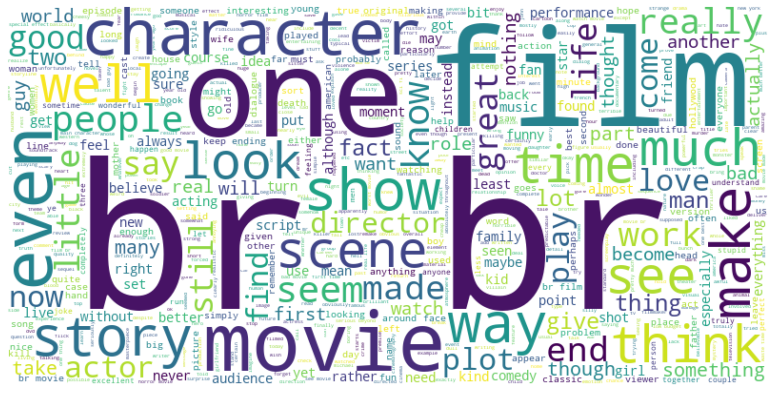

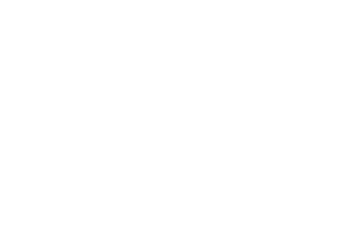

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

text = ' '.join(x_train) # join all reviews in training set
wordcount = 20000
stopwords = set(STOPWORDS)
stopwords.update(['UNK', 'PAD', 'START'])
wc = WordCloud(width=800, height=400, background_color="white", max_words=wordcount, stopwords=stopwords)
wc.generate(text)

plt.figure( figsize=(14,7) )
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.axis("off")
plt.show()

### Creating and training the models

In [6]:
# Initialize the TextClassifier
clf = ak.TextClassifier(
    max_trials=2,
    overwrite=True,
)

# Callback to avoid overfitting with the EarlyStopping.
cbs = [
    tf.keras.callbacks.EarlyStopping(patience=2),
]

# Search for the best model.
clf.fit(
    x_train,
    y_train,
    callbacks=cbs
)

Trial 2 Complete [00h 02m 49s]
val_loss: 0.32017290592193604

Best val_loss So Far: 0.27246472239494324
Total elapsed time: 00h 09m 27s
INFO:tensorflow:Oracle triggered exit
Epoch 1/2
782/782 [==============================] - 117s 149ms/step - loss: 0.5567 - accuracy: 0.6677
Epoch 2/2
782/782 [==============================] - 117s 150ms/step - loss: 0.2624 - accuracy: 0.8939
INFO:tensorflow:Assets written to: ./text_classifier/best_model/assets


### Evaluating the best model

In [7]:
# Evaluate the chosen model with testing data
clf.evaluate(x_test, y_test)

782/782 [==============================] - 28s 35ms/step - loss: 0.2907 - accuracy: 0.8834


[0.29067179560661316, 0.8834400177001953]

###Visualizing the model

In [8]:
# First we export the model to a keras model
keras_model = clf.export_model()

# Now, we ask for the model Sumary:
keras_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 1)                 0         
_________________________________________________________________
text_vectorization (TextVect (None, 512)               0         
_________________________________________________________________
embedding (Embedding)        (None, 512, 64)           320064    
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 508, 256)          82176     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0     

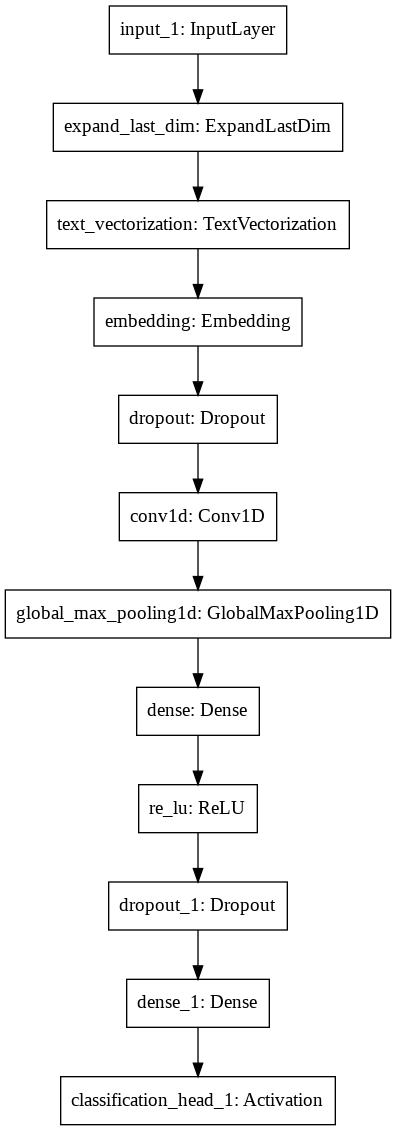

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(keras_model)

###Predicting some sentences

In [10]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
def get_sentiment(val):
    return "Positive" if val == 1 else "Negative"
for i in range(10):
    print(x_test[i])
    print("label: %s, prediction: %s" % (get_sentiment(y_test[i][0]), get_sentiment(clf.predict(x_test[i:i+1])[0][0])))


<START> please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss
label: Negative, prediction: Negative
<START> this film requires a lot of patience because it focuses on mood and character development the plot is very simple and many of the scenes take place on the same set in frances austen's the sandy dennis character apartment but the film builds to a disturbing climax br br the characters create an atmosphere rife with sexual tension and psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant perfor